In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from icecream import ic as log

In [ ]:
# reproduce a  cv2.filter2D function using numpy only
def convolute(inputImage, kernel):
    # Get the dimensions of the image and the kernel
    imageHeight, imageWidth = inputImage.shape
    kernelHeight, kernelWidth = kernel.shape
    
    padHeight = kernelHeight // 2
    padWidth = kernelWidth // 2
    
    paddedImage = np.pad(inputImage, ((padHeight, padHeight), (padWidth, padWidth)), mode='constant', constant_values=0)
    outputImage = np.zeros(inputImage.shape)
    for row in range(imageHeight):
        for col in range(imageWidth):
            roi = paddedImage[row:row + kernelHeight, col:col + kernelWidth]
            outputImage[row, col] = np.sum(roi * kernel)
    return outputImage
    

In [ ]:
# Assignment 8.1: Develop and apply the compass filter to an image and discuss the results

def compass_filter(img, threshold=0):
    '''there are 8 directions in compass filter; only 4 are used here and reverse sign of the other 4'''
    Hs0 = np.array([[-1, 0, 1], 
                    [-2, 0, 2], 
                    [-1, 0, 1]])
    Hs1 = np.array([[-2, -1, 0], 
                    [-1, 0, 1], 
                    [0, 1, 2]])
    Hs2 = np.array([[-1, -2, -1], 
                    [0, 0, 0], 
                    [1, 2, 1]])
    Hs3 = np.array([[0, -1, -2],
                    [1, 0, -1],
                    [2, 1, 0]])
    compassKernalsLst = [Hs0, Hs1, Hs2, Hs3, -Hs0, -Hs1, -Hs2, -Hs3]
    
    # init 3 dimensional array to store the result of each filter kernel
    compassFilteredImage = np.zeros((img.shape[0], img.shape[1], 8))
    for compassFilter in range(len(compassKernalsLst)):
        compassFilteredImage[:, :, compassFilter] = convolute(img, compassKernalsLst[compassFilter])
        
    # find the max value of each pixel in the 3rd dimension
    compassFilteredImageMax = np.max(compassFilteredImage, axis=2)
    
    # thresholding
    compassFilteredImageEdge = compassFilteredImageMax > threshold
    return compassFilteredImageEdge


bridgeImagePath = "images/week8/bridge.png"
bridgeImage = cv2.imread(bridgeImagePath, cv2.IMREAD_GRAYSCALE)

threshold = 10
threshold2 = 50
compassFilteredImage = compass_filter(bridgeImage, threshold)
compassFilteredImage2 = compass_filter(bridgeImage, threshold2) 

# plot original image and compass filter image
plt.figure(figsize=(20, 20))
plt.subplot(131)
plt.imshow(bridgeImage, cmap='gray')
plt.title("Original Image")
plt.subplot(132)
plt.imshow(compassFilteredImage, cmap='gray')
plt.title("Compass Filter Image with threshold {}".format(threshold))
plt.subplot(133)
plt.imshow(compassFilteredImage2, cmap='gray')
plt.title("Compass Filter Image with threshold {}".format(threshold2))
plt.show()

Text(0.5, 1.0, 'Canny Edge Detection with threshold1 0.05 and threshold2 0.1')

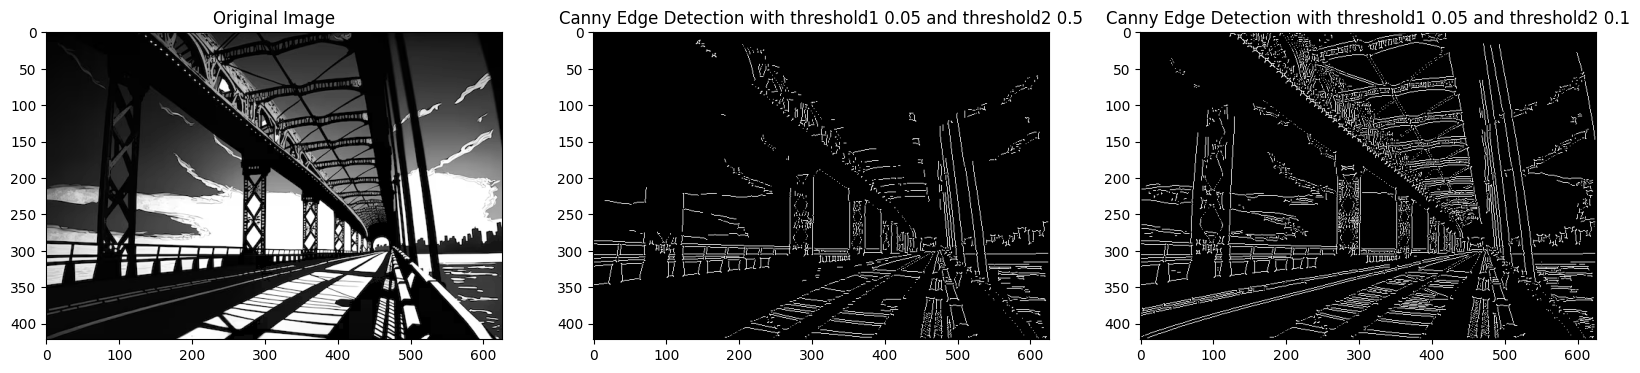

In [67]:
# Assignment 8.2: Study Canny Operator and apply to an image. Also explain how to apply it step by step.

def gaussian_blur_5(img):
    '''Gaussian blur 5*5 for noise reduction'''
    gaussianFilter5x5 = np.array([[1, 4, 6, 4, 1], 
                              [4, 16, 24, 16, 4], 
                              [6, 24, 36, 24, 6], 
                              [4, 16, 24, 16, 4], 
                              [1, 4, 6, 4, 1]]) / 256
    filteredImage = convolute(img, gaussianFilter5x5)
    return filteredImage


def sobel_filter(img):
    '''Sobel filter for gradient calculation'''
    sobelKernelX = np.array([[-1, 0, 1],
                            [-2, 0, 2],
                            [-1, 0, 1]])
    sobelKernelY = np.array([[-1, -2, -1],
                            [0, 0, 0],
                            [1, 2, 1]])
    gradientX = convolute(img, sobelKernelX)
    gradientY = convolute(img, sobelKernelY)
    gradientMagnitude = np.sqrt(gradientX ** 2 + gradientY ** 2)
    gradientAngle = np.arctan2(gradientY, gradientX)
    return gradientMagnitude, gradientAngle


def non_maximum_suppression(img, gradientAngle):
    ''' - Identify the edge direction based on the angle value from the angle matrix.
        - To check if the pixels on the same direction are more or less intense than the ones being processed.
    '''
    imageHeight, imageWidth = img.shape
    suppressedImage = np.zeros(img.shape)
    angle = gradientAngle * 180. / np.pi
    angle[angle < 0] += 180
    
    for row in range(1, imageHeight - 1):
        for col in range(1, imageWidth - 1):
            q = 255
            r = 255
            # angle 0
            if (0 <= angle[row, col] < 22.5) or (157.5 <= angle[row, col] <= 180):
                q = img[row, col + 1]
                r = img[row, col - 1]
            # angle 45
            elif (22.5 <= angle[row, col] < 67.5):
                q = img[row + 1, col - 1]
                r = img[row - 1, col + 1]
            # angle 90
            elif (67.5 <= angle[row, col] < 112.5):
                q = img[row + 1, col]
                r = img[row - 1, col]
            # angle 135
            elif (112.5 <= angle[row, col] < 157.5):
                q = img[row - 1, col - 1]
                r = img[row + 1, col + 1]
            if (img[row, col] >= q) and (img[row, col] >= r):
                suppressedImage[row, col] = img[row, col]
            else:
                suppressedImage[row, col] = 0
    return suppressedImage


def double_threshold(img, lowThreshold=0.05, highThreshold=0.09):
    '''Double thresholding is used to determine potential edges
        - highThreshold is used to identify strong edges
        - lowThreshold is used to identify weak edges
    '''
    highThreshold = img.max() * highThreshold
    lowThreshold = highThreshold * lowThreshold
    imageHeight, imageWidth = img.shape
    result = np.zeros((imageHeight, imageWidth), dtype=np.int32)
    weak = np.int32(25)
    strong = np.int32(255)
    
    strongRow, strongCol = np.where(img >= highThreshold)
    weakRow, weakCol = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    result[strongRow, strongCol] = strong
    result[weakRow, weakCol] = weak
    return result, weak, strong


def edge_tracking_by_hysteresis(img, weak, strong=255):
    '''The weak edges that are connected to strong edges are considered as strong edges, and the rest are considered as non-edges.'''
    imageHeight, imageWidth = img.shape
    for row in range(1, imageHeight - 1):
        for col in range(1, imageWidth - 1):
            if (img[row, col] == weak):
                try:
                    if ((img[row + 1, col - 1] == strong) or (img[row + 1, col] == strong) or (img[row + 1, col + 1] == strong)
                        or (img[row, col - 1] == strong) or (img[row, col + 1] == strong)
                        or (img[row - 1, col - 1] == strong) or (img[row - 1, col] == strong) or (img[row - 1, col + 1] == strong)):
                        img[row, col] = strong
                    else:
                        img[row, col] = 0
                except IndexError as e:
                    pass
    return img


def canny_edge_detection(img, threshold1=0, threshold2=0):
    '''The Canny edge detection algorithm is composed of 5 steps:
        - Noise reduction;
        - Gradient calculation;
        - Non-maximum suppression;
        - Double threshold;
        - Edge Tracking by Hysteresis.'''
    # Noise reduction
    img = gaussian_blur_5(img)
    # Gradient calculation
    gradientMagnitude, gradientAngle = sobel_filter(img)
    # Non-maximum suppression
    suppressedImage = non_maximum_suppression(gradientMagnitude, gradientAngle)
    # Double threshold
    doubleResult, weak, strong = double_threshold(suppressedImage, threshold1, threshold2)
    # Edge tracking by hysteresis
    edgeTrackingResult = edge_tracking_by_hysteresis(doubleResult, weak, strong)
    return edgeTrackingResult


bridgeImagePath = "images/week8/bridge.png"
bridgeImage = cv2.imread(bridgeImagePath, cv2.IMREAD_GRAYSCALE)
threshold1 = 0.05
threshold2 = 0.5

threshold3 = 0.05
threshold4 = 0.1
cannyEdgeDetectionResultSet1 = canny_edge_detection(bridgeImage, threshold1, threshold2)
cannyEdgeDetectionResultSet2 = canny_edge_detection(bridgeImage, threshold3, threshold4)

plt.figure(figsize=(20, 20))
plt.subplot(131)
plt.imshow(bridgeImage, cmap='gray')
plt.title("Original Image")
plt.subplot(132)
plt.imshow(cannyEdgeDetectionResultSet1, cmap='gray')
plt.title("Canny Edge Detection with threshold1 {} and threshold2 {}".format(threshold1, threshold2))
plt.subplot(133)
plt.imshow(cannyEdgeDetectionResultSet2, cmap='gray')
plt.title("Canny Edge Detection with threshold1 {} and threshold2 {}".format(threshold3, threshold4))

In [ ]:
# Assignment 8.3: Study Hough Transform and show how to use it step by step

def hough_transform(edgeImage, rhoResolution=1, thetaResolution=np.pi/180):
    '''The Hough Transform is used to detect lines in an image. The steps are:
        - Edge detection;
        - Hough Transform;
        - Peak detection;
        - Line detection.'''
    # Hough Transform find r and theta
    imageHeight, imageWidth = edgeImage.shape
    maxRho = int(np.hypot(imageHeight, imageWidth))
    
    # Accumulator array
    rhos = np.arange(-maxRho, maxRho, rhoResolution)
    thetas = np.arange(0, np.pi, thetaResolution)
    accumulator = np.zeros((2 * maxRho, len(thetas)), dtype=np.uint8)
    
    edge_points = np.argwhere(edgeImage)
    
    for y, x in edge_points:
        for thetaIndex, theta in enumerate(thetas):
            rho = int(x * np.cos(theta) + y * np.sin(theta))
            rhoIndex = np.argmin(np.abs(rhos - rho))
            accumulator[rhoIndex, thetaIndex] += 1
    return accumulator, rhos, thetas


def detect_line(accumulator, rhos, thetas, threshold):
    lines = []
    for rhoIndex, thetaIndex in np.argwhere(accumulator > threshold):
        rho = rhos[rhoIndex]
        theta = thetas[thetaIndex]
        lines.append((rho, theta))
    return lines


def draw_line(img, lines):
    for rho, theta in lines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
    return img

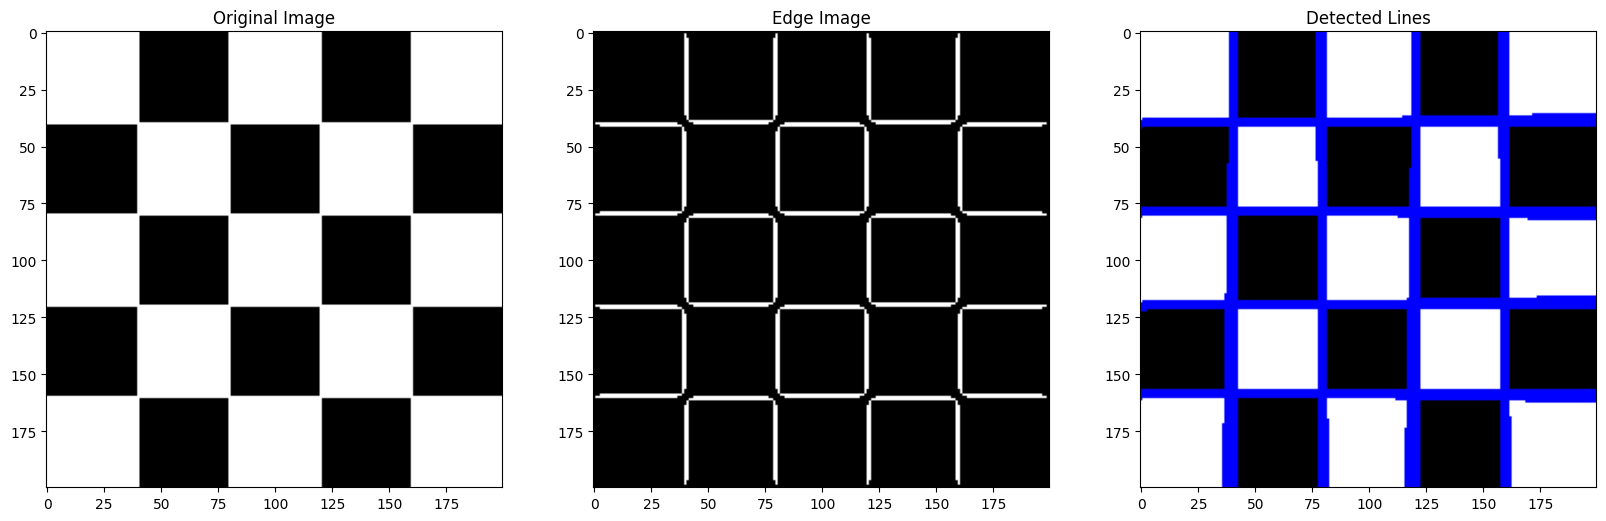

In [ ]:
chessImagePath = "images/week8/chess.png"
chessImage = cv2.imread(chessImagePath, cv2.IMREAD_GRAYSCALE)

# Step 1: Edge detection
edgeImage = canny_edge_detection(bridgeImage, 0.05, 0.5)

# Step 2: Hough Transform
accumulator, rhos, thetas = hough_transform(edgeImage)

# Step 3: Peak detection
lines = detect_line(accumulator, rhos, thetas, 100)

# Step 4: Line detection
lineImage = draw_line(cv2.cvtColor(chessImage, cv2.COLOR_GRAY2BGR), lines)

plt.figure(figsize=(20, 20))
plt.subplot(131)
plt.imshow(chessImage, cmap='gray')
plt.title("Original Image")
plt.subplot(132)
plt.imshow(edgeImage, cmap='gray')
plt.title("Edge Image")
plt.subplot(133)
plt.imshow(lineImage)
plt.title("Detected Lines")
plt.show()


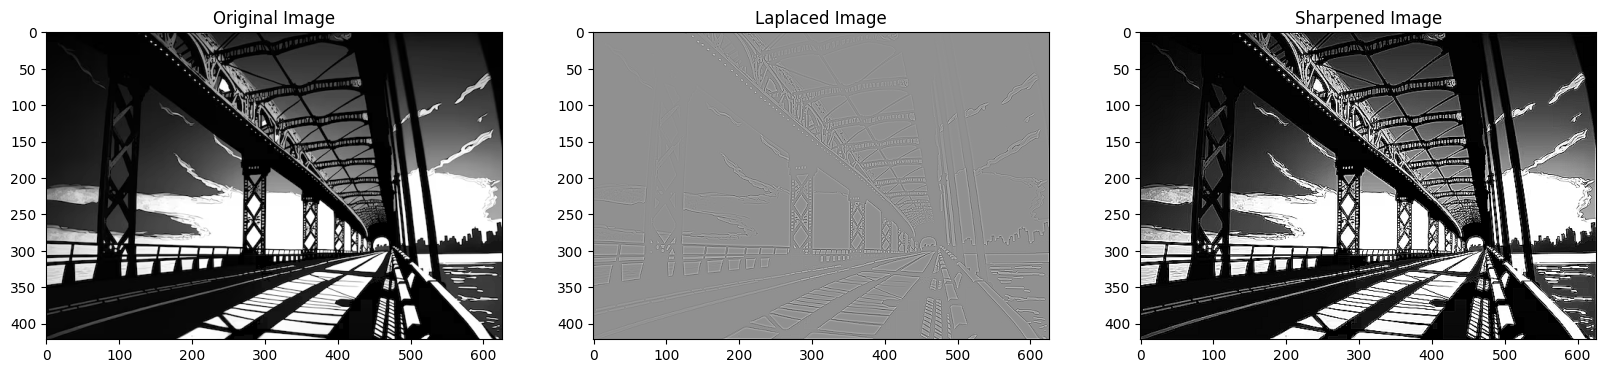

In [ ]:
# Assignment 8.4: Apply edge sharpening with the Laplace filter to an image

bridgeImagePath = "images/week8/bridge.png"
bridgeImage = cv2.imread(bridgeImagePath, cv2.IMREAD_GRAYSCALE)
laplaceKernel = np.array([[0, -1, 0],
                          [-1, 4, -1],
                          [0, -1, 0]])

laplacedImage = convolute(bridgeImage, laplaceKernel)
sharpImage = bridgeImage + laplacedImage

# rescale the backgroud to 0-255 avoiding overflow
sharpImage = np.clip(sharpImage, 0, 255).astype(np.uint8)

plt.figure(figsize=(20, 20))
plt.subplot(131)
plt.imshow(bridgeImage, cmap='gray')
plt.title("Original Image")
plt.subplot(132)
plt.imshow(laplacedImage, cmap='gray')
plt.title("Laplaced Image")
plt.subplot(133)
plt.imshow(sharpImage, cmap='gray')
plt.title("Sharpened Image")
plt.show()

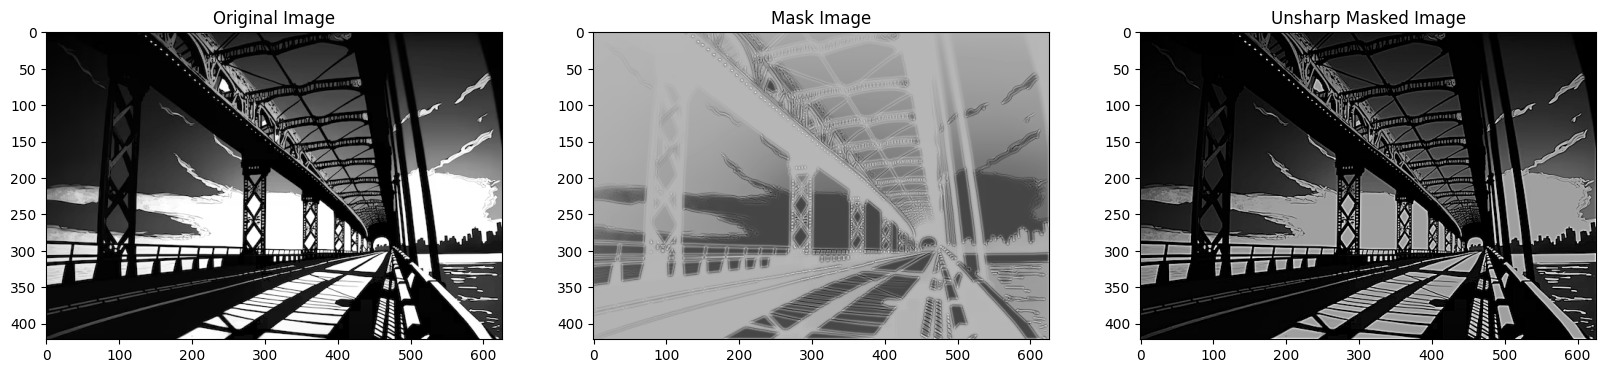

In [ ]:
# Assignment 8.5: Apply unsharp mask technique to sharpenning an image

gaussianFilter9x9 = np.array([[0, 0, 0, 1, 2, 1, 0, 0, 0], 
                              [0, 2, 3, 13, 22, 13, 3, 2, 0], 
                              [0, 3, 13, 59, 97, 59, 13, 3, 0], 
                              [1, 13, 59, 97, 159, 97, 59, 13, 1], 
                              [2, 22, 97, 159, 256, 159, 97, 22, 2], 
                              [1, 13, 59, 97, 159, 97, 59, 13, 1], 
                              [0, 3, 13, 59, 97, 59, 13, 3, 0], 
                              [0, 2, 3, 13, 22, 13, 3, 2, 0], 
                              [0, 0, 0, 1, 2, 1, 0, 0, 0]]) / 1394

bridgeImagePath = "images/week8/bridge.png"
bridgeImage = cv2.imread(bridgeImagePath, cv2.IMREAD_GRAYSCALE)
blurredImage = convolute(bridgeImage, gaussianFilter9x9)

mask = bridgeImage - blurredImage
unsharpMaskedImage = bridgeImage + (0.5 * mask)

# rescale the backgroud to 0-255 avoiding overflow
unsharpMaskedImage = np.clip(unsharpMaskedImage, 0, 255).astype(np.uint8)

plt.figure(figsize=(20, 20))
plt.subplot(131)
plt.imshow(bridgeImage, cmap='gray')
plt.title("Original Image")
plt.subplot(132)
plt.imshow(mask, cmap='gray')
plt.title("Mask Image")
plt.subplot(133)
plt.imshow(unsharpMaskedImage, cmap='gray')
plt.title("Unsharp Masked Image")
plt.show()


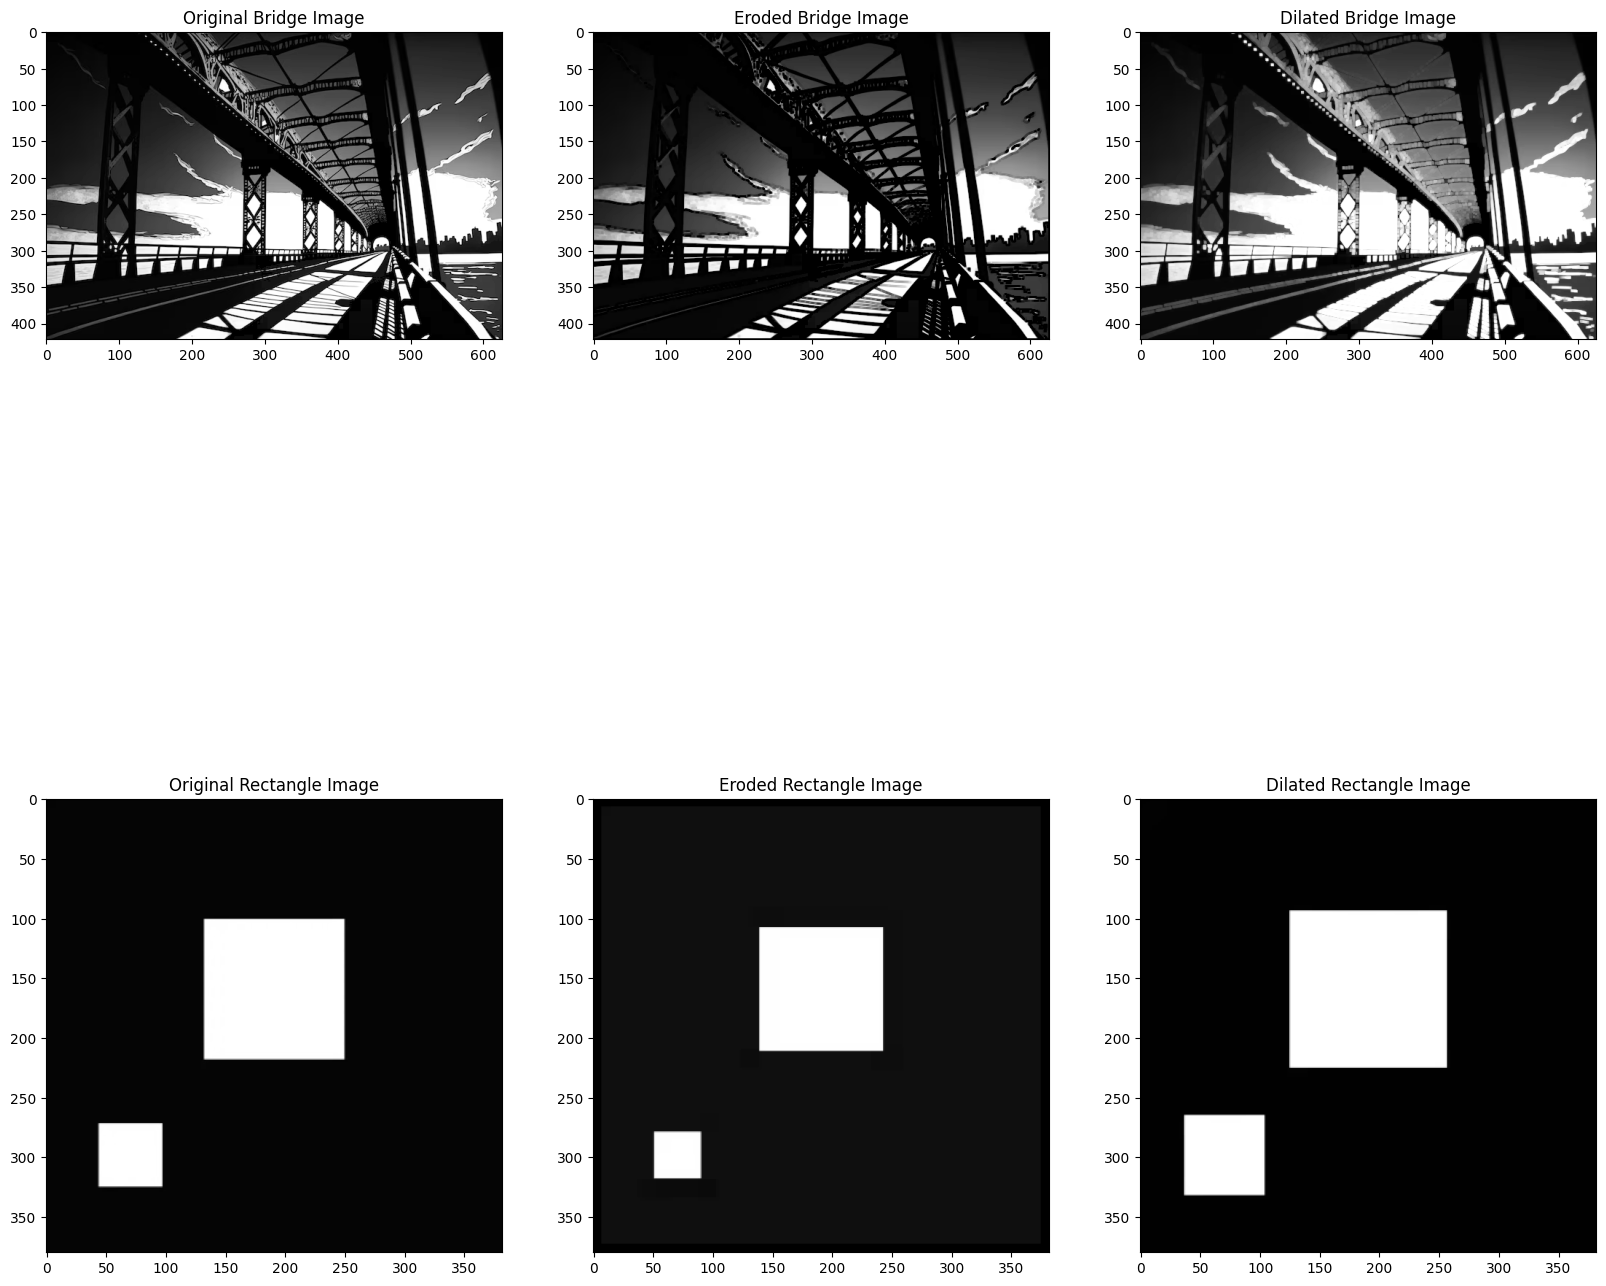

In [126]:
# Assignment 8.6: Develop and apply erosion and dilation to two images

def apply_erosion(inputImage, kernelSize=3):
    kernel = np.ones((kernelSize, kernelSize), np.uint8)
    padSize = kernelSize // 2
    paddedImage = np.pad(inputImage, padSize, mode='constant', constant_values=0)
    erodedImage = np.zeros_like(inputImage)
    
    for row in range(padSize, paddedImage.shape[0] - padSize):
        for col in range(padSize, paddedImage.shape[1] - padSize):
            region = paddedImage[row - padSize:row + padSize + 1, col - padSize:col + padSize + 1]
            erodedImage[row - padSize, col - padSize] = np.min(region * kernel)
    return erodedImage


def apply_dilation(inputImage, kernelSize=3):
    kernel = np.ones((kernelSize, kernelSize), np.uint8)
    padSize = kernelSize // 2
    paddedImage = np.pad(inputImage, padSize, mode='constant', constant_values=0)
    dilatedImage = np.zeros_like(inputImage)
    
    for row in range(padSize, paddedImage.shape[0] - padSize):
        for col in range(padSize, paddedImage.shape[1] - padSize):
            region = paddedImage[row - padSize:row + padSize + 1, col - padSize:col + padSize + 1]
            dilatedImage[row - padSize, col - padSize] = np.max(region * kernel)
    return dilatedImage


bridgeImagePath = "images/week8/bridge.png"
rectangleImagePath = "images/week8/rectangle.png"

bridgeImage = cv2.imread(bridgeImagePath, cv2.IMREAD_GRAYSCALE)
rectangleImage = cv2.imread(rectangleImagePath, cv2.IMREAD_GRAYSCALE)

erodedBridgeImage = apply_erosion(bridgeImage, 3)
erodedRectangleImage = apply_erosion(rectangleImage, 15)

dilatedBridgeImage = apply_dilation(bridgeImage, 3)
dilatedRectangleImage = apply_dilation(rectangleImage, 15)

plt.figure(figsize=(20, 20))
plt.subplot(231)
plt.imshow(bridgeImage, cmap='gray')
plt.title("Original Bridge Image")
plt.subplot(232)
plt.imshow(erodedBridgeImage, cmap='gray')
plt.title("Eroded Bridge Image")
plt.subplot(233)
plt.imshow(dilatedBridgeImage, cmap='gray')
plt.title("Dilated Bridge Image")
plt.subplot(234)
plt.imshow(rectangleImage, cmap='gray')
plt.title("Original Rectangle Image")
plt.subplot(235)
plt.imshow(erodedRectangleImage, cmap='gray')
plt.title("Eroded Rectangle Image")
plt.subplot(236)
plt.imshow(dilatedRectangleImage, cmap='gray')
plt.title("Dilated Rectangle Image")
plt.show()


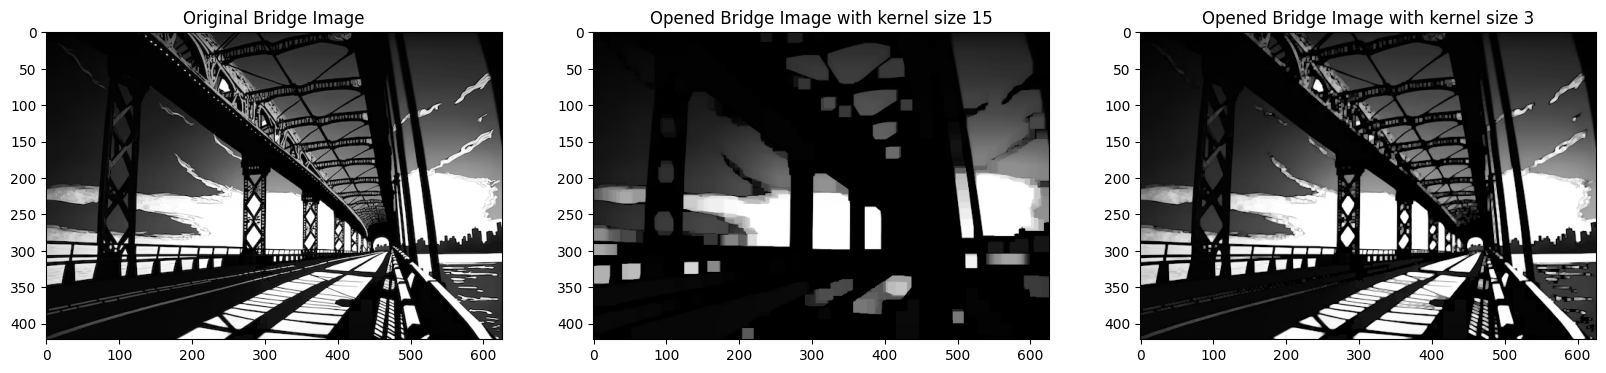

In [134]:
# Assignment 8.7: Apply opening to an image

def manualOpening(inputImage, kernelSize=3):
    erodedImage = apply_erosion(inputImage, kernelSize)
    openedImage = apply_dilation(erodedImage, kernelSize)
    return openedImage

bridgeImagePath = "images/week8/bridge.png"
bridgeImage = cv2.imread(bridgeImagePath, cv2.IMREAD_GRAYSCALE)
openedBridgeImage15 = manualOpening(bridgeImage, 15)
openedBridgeImage3 = manualOpening(bridgeImage, 3)

# 3 column 2 row
plt.figure(figsize=(20, 20))
plt.subplot(231)
plt.imshow(bridgeImage, cmap='gray')
plt.title("Original Bridge Image")
plt.subplot(232)
plt.imshow(openedBridgeImage15, cmap='gray')
plt.title("Opened Bridge Image with kernel size 15")
plt.subplot(233)
plt.imshow(openedBridgeImage3, cmap='gray')
plt.title("Opened Bridge Image with kernel size 3")
plt.show()

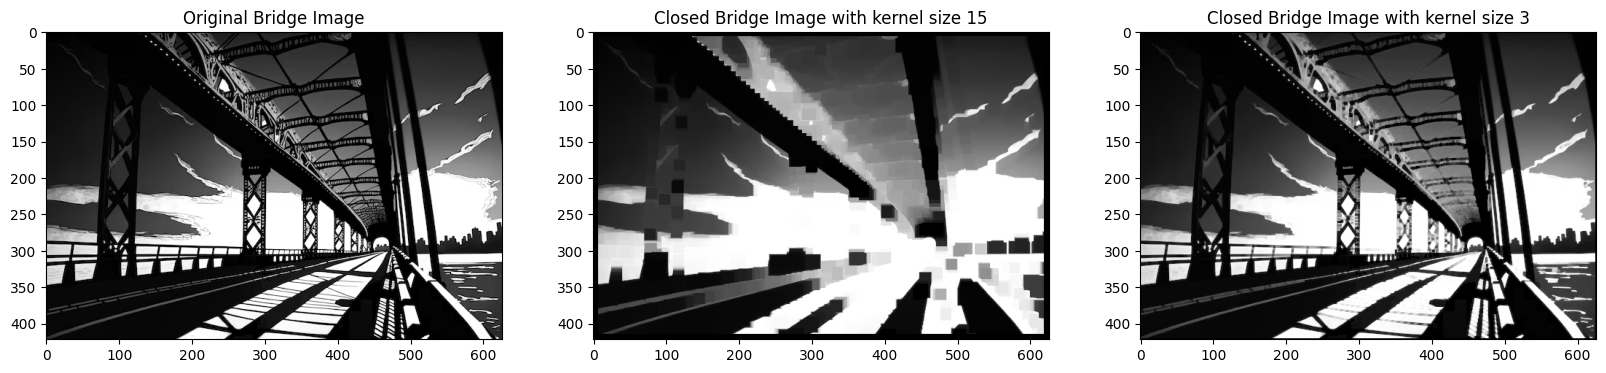

In [135]:
# Assignment 8.8: Apply closing to an image

def manualClosing(inputImage, kernelSize=3):
    dilatedImage = apply_dilation(inputImage, kernelSize)
    closedImage = apply_erosion(dilatedImage, kernelSize)
    return closedImage

bridgeImagePath = "images/week8/bridge.png"
bridgeImage = cv2.imread(bridgeImagePath, cv2.IMREAD_GRAYSCALE)
closedBridgeImage15 = manualClosing(bridgeImage, kernelSize=15)
closedBridgeImage3 = manualClosing(bridgeImage, kernelSize=3)

plt.figure(figsize=(20, 20))
plt.subplot(231)
plt.imshow(bridgeImage, cmap='gray')
plt.title("Original Bridge Image")
plt.subplot(232)
plt.imshow(closedBridgeImage15, cmap='gray')
plt.title("Closed Bridge Image with kernel size 15")
plt.subplot(233)
plt.imshow(closedBridgeImage3, cmap='gray')
plt.title("Closed Bridge Image with kernel size 3")
plt.show()